# Final Project

imports:

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, auc
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

loading data:

In [253]:
# load
def loading_csv(csv_name):
    D = pd.read_csv(csv_name)
    D = D.drop(columns=["id"])
    return D

data = loading_csv("train.csv")

splitting data to numeric and object:

In [254]:
numeric_cols = data.select_dtypes(include=[np.number]).columns
object_cols = data.select_dtypes(include=[np.object]).columns

print(f'numeric: {numeric_cols.shape}, obj: {object_cols.shape}')

numeric: (14,), obj: (8,)


array([[<AxesSubplot:title={'center':'num_of_admin_pages'}>,
        <AxesSubplot:title={'center':'admin_page_duration'}>,
        <AxesSubplot:title={'center':'num_of_info_pages'}>,
        <AxesSubplot:title={'center':'num_of_product_pages'}>],
       [<AxesSubplot:title={'center':'total_duration'}>,
        <AxesSubplot:title={'center':'BounceRates'}>,
        <AxesSubplot:title={'center':'ExitRates'}>,
        <AxesSubplot:title={'center':'PageValues'}>],
       [<AxesSubplot:title={'center':'closeness_to_holiday'}>,
        <AxesSubplot:title={'center':'device'}>,
        <AxesSubplot:title={'center':'Region'}>,
        <AxesSubplot:title={'center':'B'}>],
       [<AxesSubplot:title={'center':'D'}>,
        <AxesSubplot:title={'center':'purchase'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

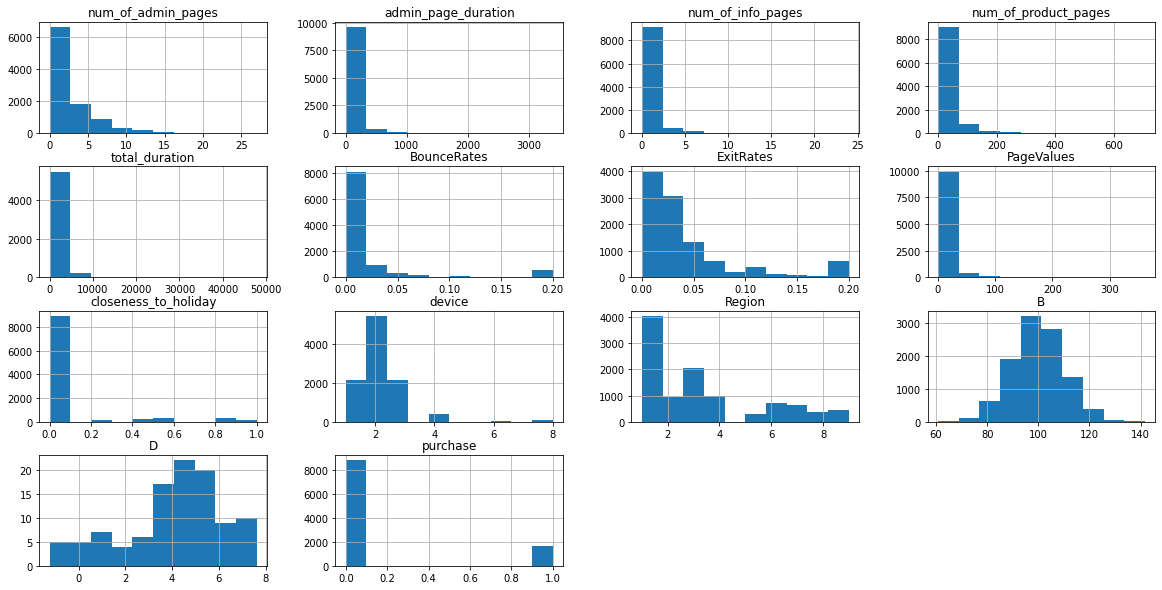

In [255]:
data[numeric_cols].hist(figsize=(20,10))
#see appendix 2.1 in the final report

We want to check how the non-numeric colunms look, so we can manipulate it and change it to numeric data.

In [256]:
for col in object_cols:
    print(col)
    print("=" * len(col))
    print(data[col].value_counts())

info_page_duration
0.0 minutes       8176
9.0 minutes         28
10.0 minutes        23
6.0 minutes         23
7.0 minutes         23
                  ... 
43.2 minutes         1
246.8 minutes        1
274.0 minutes        1
13.4 minutes         1
211.25 minutes       1
Name: info_page_duration, Length: 1089, dtype: int64
product_page_duration
0.0 minutes            594
17.0 minutes            16
8.0 minutes             16
15.0 minutes            14
19.0 minutes            14
                      ... 
914.5060606 minutes      1
446.8333333 minutes      1
551.6666667 minutes      1
723.25 minutes           1
346.0 minutes            1
Name: product_page_duration, Length: 7803, dtype: int64
Month
=====
May     2857
Nov     2539
Mar     1615
Dec     1450
Oct      471
Sep      379
Jul      367
Aug      365
June     248
Feb      163
Name: Month, dtype: int64
internet_browser
chrome_89         1117
chrome_99.1.3     1101
chrome_99.1.4     1080
chrome_98.0.1     1078
chrome_90.1.7     1038


We will convert object to numaric and creating new columns for returning and new costumers, for different browsers and for column C

In [257]:
#stripping strings from numeric values
def strip_string(D):
    D["info_page_duration"] = D["info_page_duration"].str[:-8]
    D["info_page_duration"] = D["info_page_duration"].astype(np.float)
    D["product_page_duration"] = D["product_page_duration"].str[:-8]
    D["product_page_duration"] = D["product_page_duration"].astype(np.float)

#converting months' names to numbers
def month_converter(D):
    month_list = ["Jan", "Feb", "Mar", "Apr", "May", "June", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    month_dict = dict([(month_list[i], i + 1) for i in range(len(month_list))])
    D.replace({"Month": month_dict}, inplace=True)

#converting true-false strings to numeric values
def weekend_converter(D):
    D["Weekend"] = D["Weekend"].astype(np.bool)
    D["Weekend"] = D["Weekend"].astype(np.int)
    
def create_user_type(D):
    D['is_returning'] = D.apply(lambda row: 1 if row.user_type == 'Returning_Visitor' else 0, axis=1)
    D['is_new'] = D.apply(lambda row: 1 if row.user_type == 'New_Visitor' else 0, axis=1)
    
def create_browser_type(D):
    D['is_safari'] = D['internet_browser'].str.startswith('safari').astype(float)
    D['is_chrome'] = D['internet_browser'].str.startswith('chrome').astype(float)
    D['is_browser'] = D['internet_browser'].str.startswith('browser').astype(float)
    D['is_edge'] = D['internet_browser'].str.startswith('edge').astype(float)
    
def A_converter(D):
    D["A"] = D["A"].str[2:]
    D["A"] = D["A"].str.replace('_', '.').astype(float)
    
def create_logs(D):
    logs = ['log_100', 'log200', 'log202', 'log400', 'log404', 'log8080']
    for log in logs:
        D['is_' + log] = D.apply(lambda row: 1 if row.C == log else 0, axis=1)

def transform_data(D):
    strip_string(D)
    month_converter(D)
    weekend_converter(D)
    create_user_type(D)
    create_browser_type(D)
    A_converter(D)
    create_logs(D)
    old_cols = ["C", "user_type", "internet_browser"]
    for col in old_cols:
        D.drop(col, axis=1, inplace=True)
    return(D)

data = transform_data(data)

array([[<AxesSubplot:title={'center':'num_of_admin_pages'}>,
        <AxesSubplot:title={'center':'admin_page_duration'}>,
        <AxesSubplot:title={'center':'num_of_info_pages'}>,
        <AxesSubplot:title={'center':'info_page_duration'}>,
        <AxesSubplot:title={'center':'num_of_product_pages'}>,
        <AxesSubplot:title={'center':'product_page_duration'}>],
       [<AxesSubplot:title={'center':'total_duration'}>,
        <AxesSubplot:title={'center':'BounceRates'}>,
        <AxesSubplot:title={'center':'ExitRates'}>,
        <AxesSubplot:title={'center':'PageValues'}>,
        <AxesSubplot:title={'center':'closeness_to_holiday'}>,
        <AxesSubplot:title={'center':'Month'}>],
       [<AxesSubplot:title={'center':'device'}>,
        <AxesSubplot:title={'center':'Region'}>,
        <AxesSubplot:title={'center':'Weekend'}>,
        <AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'B'}>,
        <AxesSubplot:title={'center':'D'}>],
       [<AxesSubplo

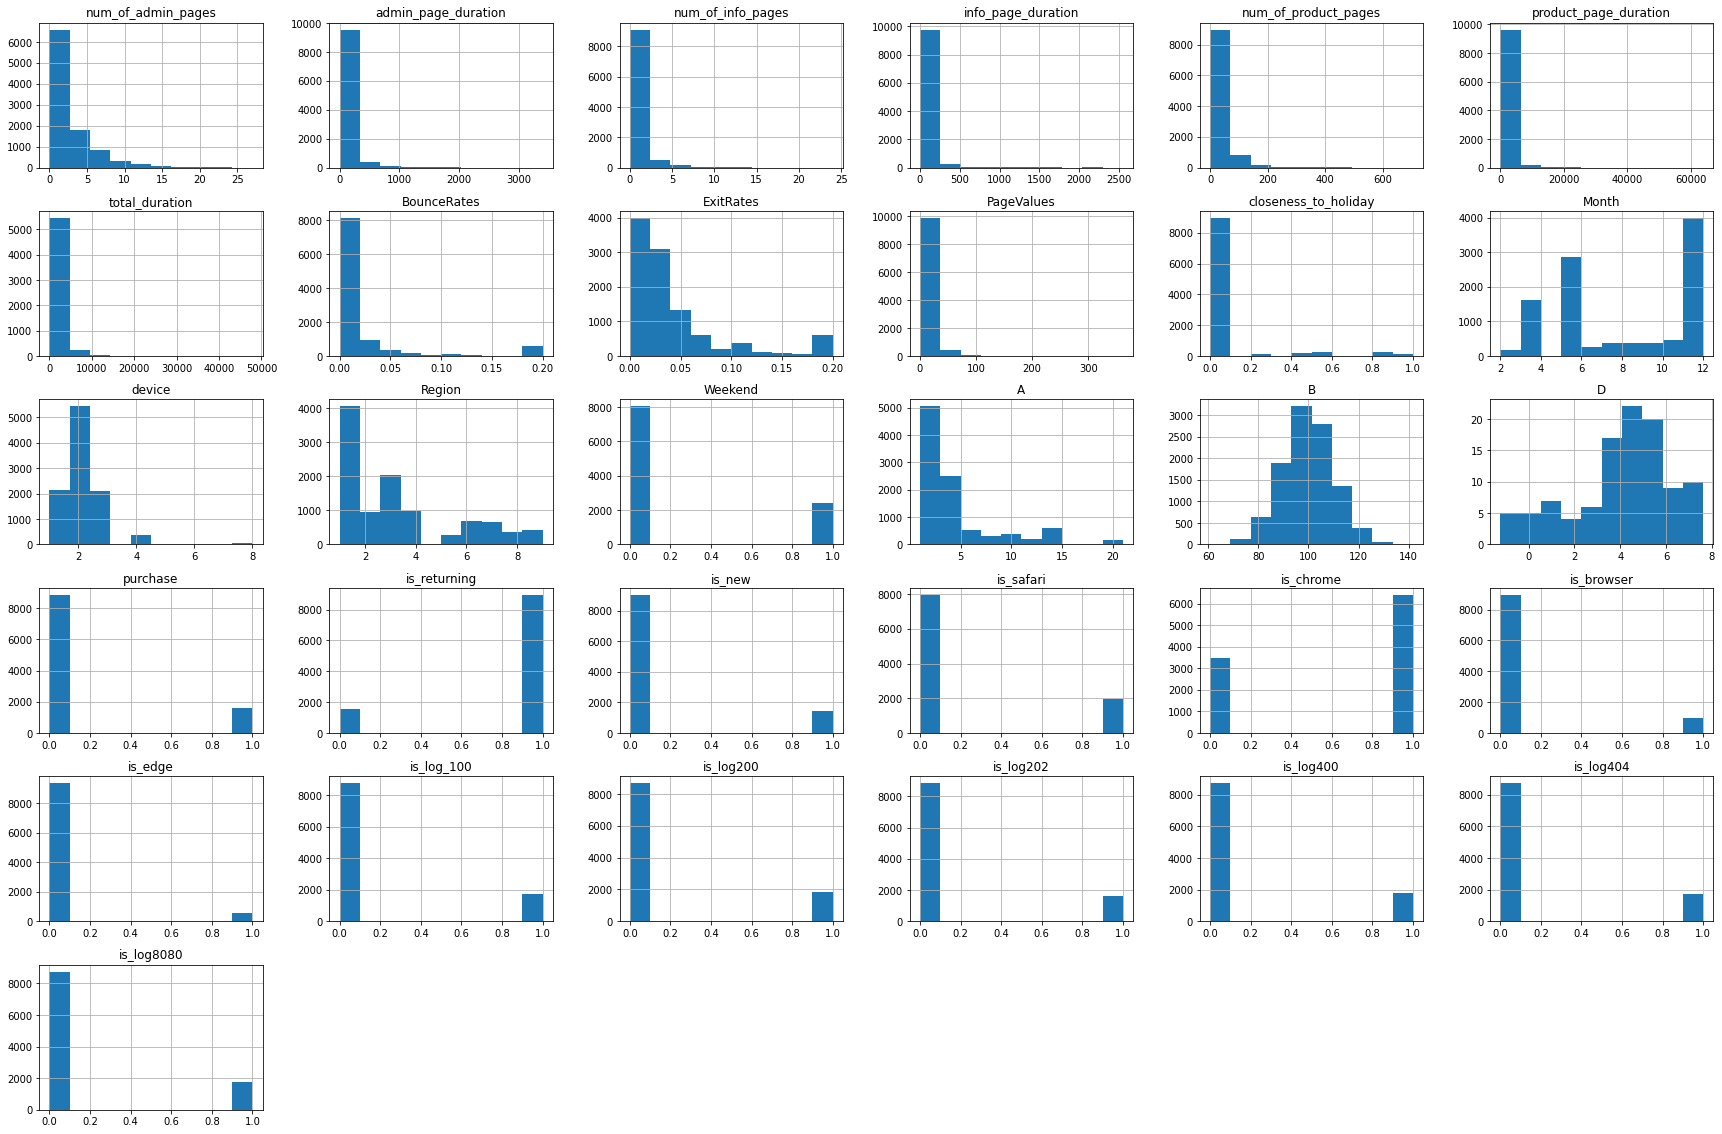

In [258]:
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols].hist(figsize=(30,20))
#see appendix 2.1 in the final report

We want to check corralations between different types of data to the lable, because it might give us some more insite on how we should fill the missing values

<AxesSubplot:>

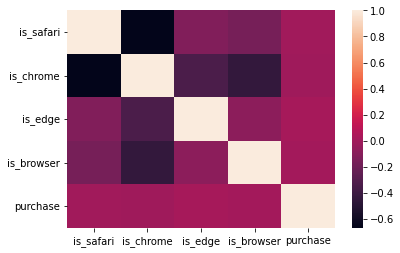

In [259]:
#Corralation between browser type to purchase
corr = data[['is_safari','is_chrome', 'is_edge','is_browser','purchase']].corr()
sns.heatmap(corr)
#see appendix 2.2 in the final report

<AxesSubplot:>

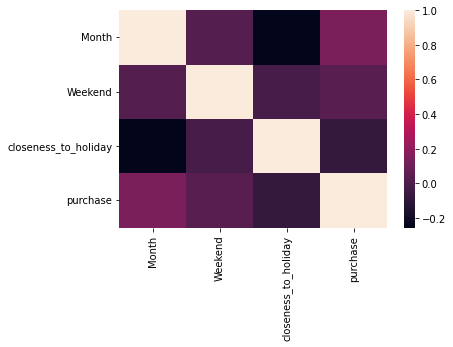

In [260]:
#Corralation between date data to purchase
corr = data[['Month','Weekend', 'closeness_to_holiday', 'purchase']].corr()
sns.heatmap(corr)
#see appendix 2.2 in the final report

<AxesSubplot:>

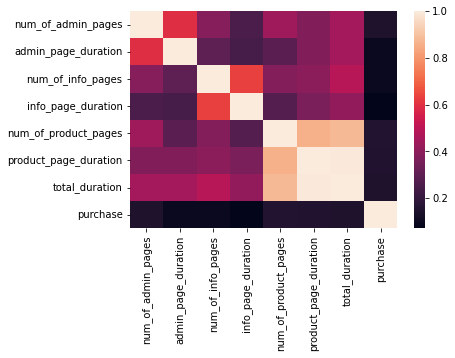

In [261]:
#Corralation between page info to purchase
corr = data[['num_of_admin_pages','admin_page_duration', 'num_of_info_pages', 'info_page_duration', 
             'num_of_product_pages','product_page_duration','total_duration', 'purchase']].corr()
sns.heatmap(corr)
#see appendix 2.2 in the final report

<AxesSubplot:>

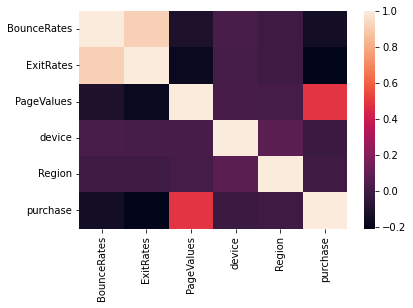

In [262]:
#Corralation between browsing info to purchase
corr = data[['BounceRates','ExitRates', 'PageValues', 'device', 'Region', 'purchase']].corr()
sns.heatmap(corr)
#see appendix 2.2 in the final report

<AxesSubplot:>

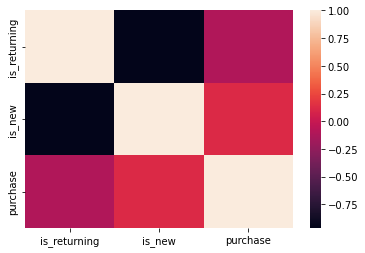

In [263]:
#corralation between user type to purchase
corr = data[['is_returning', 'is_new', 'purchase']].corr()
sns.heatmap(corr)
#see appendix 2.2 in the final report

<AxesSubplot:>

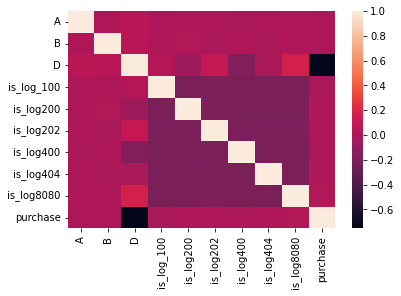

In [264]:
#Corralation between anonymous cols to purchase
corr = data[['A', 'B', 'D','is_log_100','is_log200' ,'is_log202', 'is_log400', 'is_log404', 'is_log8080', 'purchase']].corr()
sns.heatmap(corr)
#see appendix 2.2 in the final report

We counl't find any strong, meaningful correlation. We will run a forward selection algorithm to determine the most important colunms. 
Now we know more about our data and can use it to fill missing values.

Checking null entries

In [265]:
nulls_train = data.isnull().sum()
nulls_train[nulls_train>0]

num_of_admin_pages         605
admin_page_duration        413
num_of_info_pages          687
info_page_duration         317
num_of_product_pages       403
product_page_duration      621
total_duration            4753
BounceRates                 22
ExitRates                   26
PageValues                  27
closeness_to_holiday       496
Month                       25
device                     323
Region                      19
A                          706
B                           23
D                        10374
is_safari                  563
is_chrome                  563
is_browser                 563
is_edge                    563
dtype: int64

We will change all missing duration values and number of pages to the mean value
Need to visualize months to figure out the distribution
If less than 30 missing values, will add NaN

<AxesSubplot:>

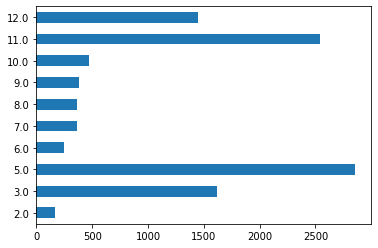

In [266]:
data["Month"].value_counts().sort_index().plot(kind="barh")
#see appendix 2.3 in the final report

We can see that the most common month is May, so and missing value in this column will be changed to May (5.0)

In [267]:
cols_fill_dict = {"Month": 5.0}

We will fill column D in 0s, because most of the data is missing

In [268]:
cols_fill_dict["D"] = 0

We will find the most common browser and change the values acordingly

<AxesSubplot:>

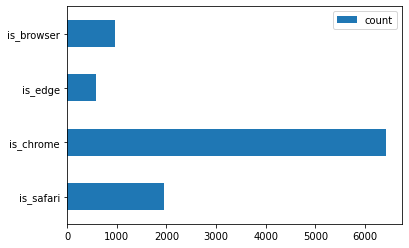

In [269]:
browsers = ["is_safari", "is_chrome", "is_edge", "is_browser"]
count_browsers = dict([(b, data[b].sum()) for b in browsers])
count_browsers = pd.DataFrame(data=count_browsers, index=["count"]).transpose()
count_browsers.plot(kind="barh")
#see appendix 2.3 in the final report

Chrome is the most used browser, so we will fill the missing values in "is_chrome" with 1, and the rest with 0
We will also remove the "internet_browser"column because it is no longer necesary

In [270]:
for i in browsers:
    cols_fill_dict[i] = 0
    
cols_fill_dict["is_chrome"] = 1

For product, admin and info pages, we can see a corralertion between the number of pages visited and the time spent on them, so we will fill the missing values using the median ratio between them.

Total duration is the sum of all the duration columns, so we will fill the missing values according to these colunms.

We will fill 'BounceRates', 'ExitRates' using the median value, and 'PageValues' with 0 - the most common value.

In [271]:
cols_fill_dict["BounceRates"] = data["BounceRates"].median()
cols_fill_dict["ExitRates"] = data["ExitRates"].median()
cols_fill_dict["PageValues"] = 0

We will fill the missing values of 'device' and 'region'colunms according to the most common values in them.

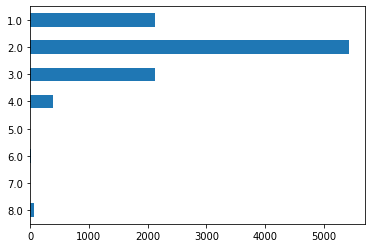

In [272]:
count_devices = data["device"].value_counts().sort_index(ascending=False).plot(kind="barh")
#see appendix 2.3 in the final report
cols_fill_dict["device"] = 2.0

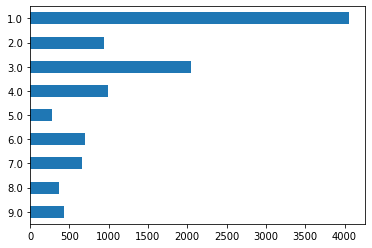

In [273]:
count_regions = data["Region"].value_counts().sort_index(ascending=False).plot(kind="barh")
#see appendix 2.3 in the final report
cols_fill_dict["Region"] = 1.0

We can see that 'is_returning' is the more common value, so we will fill the missing values as 'returning'.

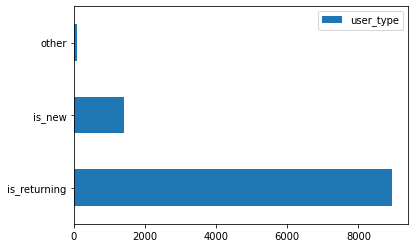

In [274]:
users = ['is_returning', 'is_new']
count_users = dict([(u, data[u].sum()) for u in users])
count_users['other'] = data.shape[0] - count_users['is_returning'] - count_users['is_new']
count_users = pd.DataFrame(data=count_users, index=["user_type"]).transpose()
count_users.plot(kind="barh")

#see appendix 2.3 in the final report
cols_fill_dict["is_returning"] = 1
cols_fill_dict["is_new"] = 0

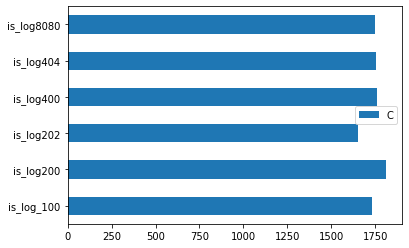

In [275]:
logs_list = ['is_log_100','is_log200' ,'is_log202', 'is_log400', 'is_log404', 'is_log8080']
count_logs = dict([(l, data[l].sum()) for l in logs_list])
count_logs = pd.DataFrame(data=count_logs, index=["C"]).transpose()
count_logs.plot(kind="barh")

#log_200 means everything is ok, so this will be the default
#see appendix 2.3 in the final report
for log in logs_list:
    cols_fill_dict[log] = 0

cols_fill_dict["is_log200"] = 1

In [276]:
#Column B is of normal destribulion, and for that reason we will fill the null cells with the mean value
cols_fill_dict["B"] = data["B"].mean()

In [277]:
#using median value to fill missing valuse
cols_fill_dict["A"] = data["A"].median()

In [278]:
#the median is 0 for all months, so we will use mean
closeness_dict = dict(data.groupby("Month").mean()["closeness_to_holiday"])
for i in range(1, 13):
    if i not in closeness_dict.keys():
        closeness_dict[float(i)] = 0.0

def fill_col(D, col_name, x):
    D[col_name].fillna(x, inplace=True)



def fill_prod(D):
    product_rows_with_na = [index for index in range(len(D)) if (pd.isna(D.at[index, "num_of_product_pages"]) & 
                                                        pd.isna(D.at[index, "product_page_duration"]))]
    med_num_prod_pages = D["num_of_product_pages"].median()
    product_fill_null = (D["product_page_duration"]/D["num_of_product_pages"]).median()
    D.loc[product_rows_with_na, "num_of_product_pages"] = med_num_prod_pages
    D["product_page_duration"].fillna(product_fill_null*D["num_of_product_pages"], inplace=True)
    D["num_of_product_pages"].fillna((1/product_fill_null)*D["product_page_duration"], inplace=True)


def fill_admin(D):
    admin_rows_with_na = [index for index in range(len(D)) if (pd.isna(D.at[index, "num_of_admin_pages"]) & 
                                                        pd.isna(D.at[index, "admin_page_duration"]))]
    med_num_admin_pages = D["num_of_admin_pages"].median()
    admin_fill_null = (D["admin_page_duration"]/D["num_of_admin_pages"]).median()
    D.loc[admin_rows_with_na, "num_of_admin_pages"] = med_num_admin_pages
    D["admin_page_duration"].fillna(admin_fill_null*D["num_of_admin_pages"], inplace=True)
    D["num_of_admin_pages"].fillna((1/admin_fill_null)*D["admin_page_duration"], inplace=True)
    


def fill_info(D):
    info_rows_with_na = [index for index in range(len(D)) if (pd.isna(D.at[index, "num_of_info_pages"]) & 
                                                            pd.isna(D.at[index, "info_page_duration"]))]
    med_num_info_pages = D["num_of_info_pages"].median()
    info_fill_null = (D["info_page_duration"]/D["num_of_info_pages"]).median()
    D.loc[info_rows_with_na, "num_of_info_pages"] = med_num_info_pages
    D["info_page_duration"].fillna(info_fill_null*D["num_of_info_pages"], inplace=True)
    D["num_of_info_pages"].fillna((1/info_fill_null)*D["info_page_duration"], inplace=True)
    
def fill_all_nas(D, cols_dict, close_dict):
    fill_prod(D)
    fill_admin(D)
    fill_info(D)
    D["total_duration"].fillna(D["info_page_duration"]+D["admin_page_duration"]+D["product_page_duration"], inplace=True)
    for col in cols_dict:
        fill_col(D, col, cols_dict[col])
    D["closeness_to_holiday"].fillna(D["Month"].map(close_dict), inplace=True)
    
fill_all_nas(data, cols_fill_dict, closeness_dict)

In [279]:
nulls_train = data.isnull().sum()
nulls_train[nulls_train>0]

Series([], dtype: int64)

Searching for outliers
We now want to check if there are any clear outliers that we would like to ignore. We saw 3 features in the histogram that mught be interesting to check: 'total_duration', 'B', 'D'.

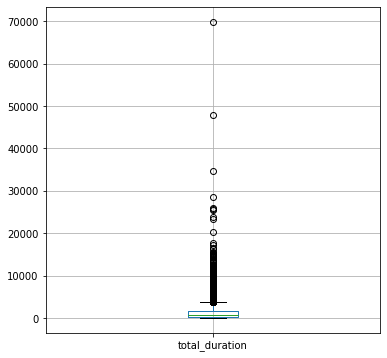

In [280]:
total_box = data.boxplot(column=["total_duration"], figsize=(6,6))
#We saw in the histogram that there is a very clear outlier, and we can see in in the boxplot as well, so we will delete it
#see appendix 2.4 in the final report

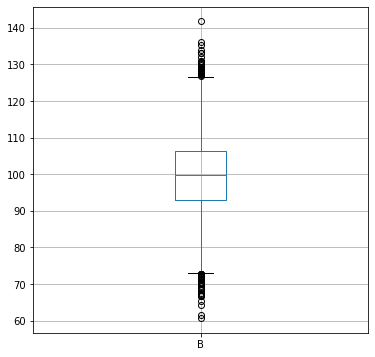

In [281]:
B_box = data.boxplot(column=["B"], figsize=(6,6))
#see appendix 2.4 in the final report

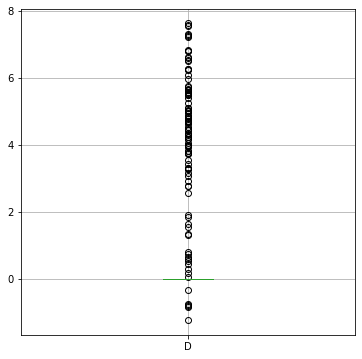

In [282]:
D_box = data.boxplot(column=["D"], figsize=(6,6))
#see appendix 2.4 in the final report

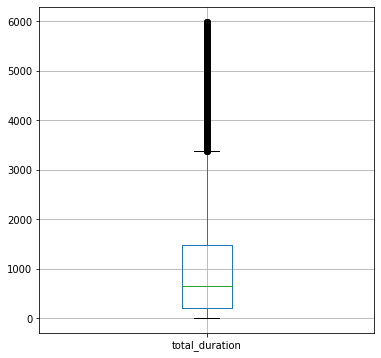

In [283]:
data.drop(data[data.total_duration>6000].index, inplace=True)

new_total_box = data.boxplot(column=["total_duration"], figsize=(6,6))
#see appendix 2.4 in the final report

# Starting to train the models

First, we will select which features to use in our models, using forward selection.

In [284]:
target_col = data.pop("purchase")
data.insert(30, "purchase", target_col)

X, y = data.values[:,:-1], data.values[:, -1]
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size = 0.25, random_state = 9)
#apply all manipulations on test data as well

log_reg = LogisticRegression(max_iter=1000)

cols_name = data.columns[:-1]
features = {}
acc_lst = []

for k in range(2,12):
    sfs = SequentialFeatureSelector(log_reg, n_features_to_select=k)
    sfs.fit(X_train, y_train)
    SequentialFeatureSelector(estimator=LogisticRegression,
                              n_features_to_select=k)
    log_reg.fit(X_train[:, sfs.get_support()], y_train)
    pred = log_reg.predict(X_val[:, sfs.get_support()])
    acc = accuracy_score(y_val, pred)
    acc_lst.append(acc)
    features[k] = sfs.get_support()

fig = plt.figure(figsize=(6, 6))
plt.plot(list(features.keys()), acc_lst)
plt.title('Accuracy per Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
fig.tight_layout()
plt.show()

#see appendix 2.5 in the final report

We can see a clear local minimum of accuracy around 10 features, therefore we will choose 9 features.

In [ ]:
data_cols_np = np.array(data.columns[:-1])

#creating new array with the selected features
X_train_new = X_train[:, features[9]]
X_val_new = X_val[:, features[9]]

### KNN

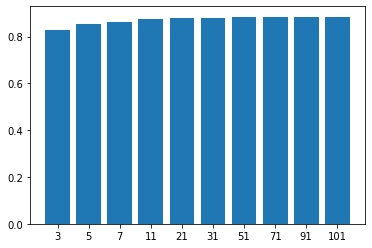

In [ ]:
#k-fold cross validadion with k = 20
kfmodel = KFold(n_splits = 20, shuffle=True, random_state=0)
X_new = X[:, features[9]]

#choose neighbors
neighbors = [3, 5, 7, 11, 21, 31, 51, 71, 91, 101]
scores = {}
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_new, y)
    score_kfold_knn = cross_val_score(knn, X_new, y, scoring='roc_auc', cv=kfmodel)
    scores[neighbor] = score_kfold_knn.mean()


vals = list(scores.values())
plt.bar(range(len(neighbors)), vals, tick_label=neighbors)
plt.show()
#see appendix 2.5 in the final report

There appears to be an elbow around 11, so we will use 11 neighbors in our model.

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=11)
knn_model.fit(X_train_new, y_train)
knn_pred = knn_model.predict(X_val_new)

### Logistic Regression

In [ ]:
#train logistic regression model
log_reg_model = LogisticRegression(max_iter=500)
log_reg_model.fit(X_train_new, y_train)
log_reg_pred = log_reg_model.predict(X_val_new)

In [ ]:
#scores for k-fold cross validadion with k = 20 for both models
kfmodel = KFold(n_splits = 20, shuffle=True, random_state=0)
X_new = X[:, features[9]]
scores_kfold_reg = cross_val_score(log_reg_model, X_new, y, scoring='roc_auc', cv=kfmodel)
scores_kfold_knn = cross_val_score(knn_model, X_new, y, scoring='roc_auc', cv=kfmodel)

### Decidion Tree

In [ ]:
params = {'max_depth': list(range(2, 16)), 'min_samples_leaf': list(range(1,5)), 'min_samples_split': list(range(2,7))}
decision_tree = DecisionTreeClassifier(random_state = 0)
search = GridSearchCV(decision_tree, params, scoring='roc_auc')
search.fit(X_train, y_train)
best_params = search.best_params_

best_decition_tree = DecisionTreeClassifier(**best_params, random_state = 0)
best_decition_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=4, random_state=0)

In [ ]:
best_params

{'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}

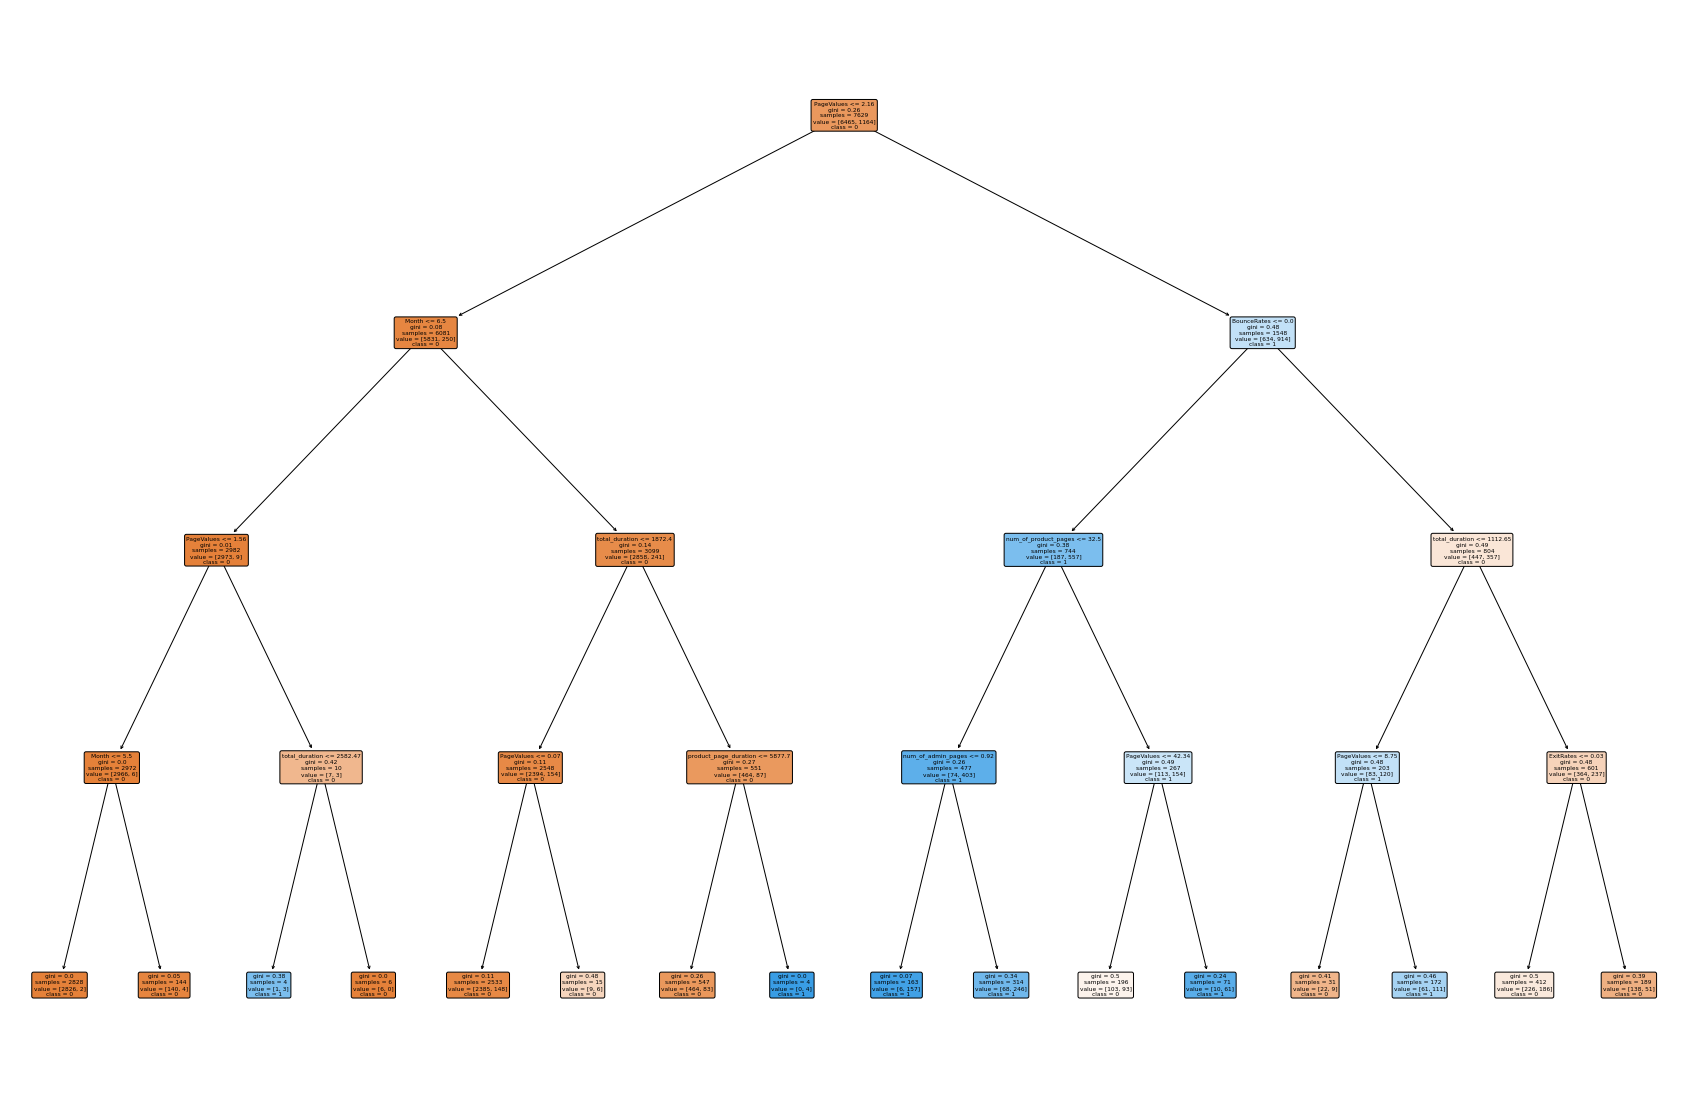

In [ ]:
plt.figure(figsize=(30,20))
dot_data  = plot_tree(decision_tree=best_decition_tree, 
                    feature_names = data_cols_np,
                    class_names = ["0","1"],
                    rounded = True, proportion = False, impurity = True,
                    label='all', precision = 2, filled = True) 

#see appendix 2.6 in the final report

In [ ]:
pred_tree = best_decition_tree.predict(X_val)
scores_kfold_tree = cross_val_score(best_decition_tree, X_new, y, scoring='roc_auc', cv=kfmodel)

### Random Forest

In [ ]:
#Building a forest
forest_params = {'max_depth': list(range(2, 16)), 'min_samples_leaf': list(range(1,5)), 'min_samples_split': list(range(2,7))}
forest = RandomForestClassifier(random_state = 0)
search_forest = GridSearchCV(forest, forest_params, scoring='roc_auc')
search_forest.fit(X_train, y_train)
best_forest_params = search_forest.best_params_

In [ ]:
best_forest_params

{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}

In [ ]:
best_forest = RandomForestClassifier(**best_forest_params, random_state = 0)
best_forest.fit(X_train, y_train)
forest_pred_val = best_forest.predict(X_val)
forest_pred_train = best_forest.predict(X_train)
acc_train = accuracy_score(y_train, forest_pred_train)
acc_val = accuracy_score(y_val, forest_pred_val)

When comparing the train and validation accuracy, we can see they are quite close. Of course the train score is higher then the validation score, but not to such extent that we will suspect overfitting.

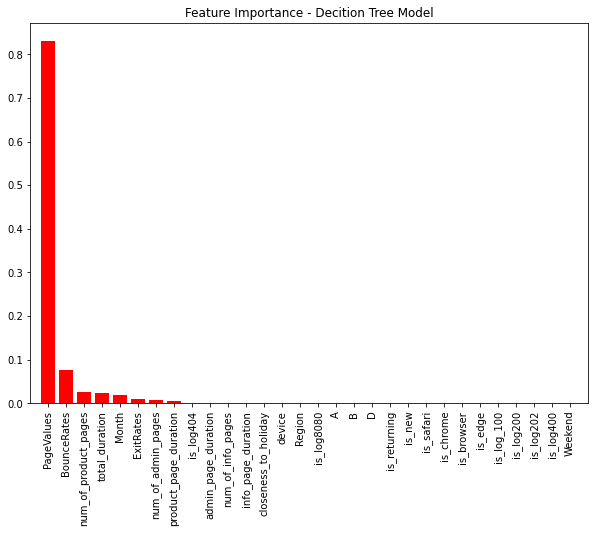

In [ ]:
feats = best_decition_tree.feature_importances_
idx = np.argsort(feats)[::-1]

#plot
plt.figure(figsize=(10,7))
plt.title('Feature Importance - Decition Tree Model')
plt.bar(range(X.shape[1]), feats[idx],
       color="r", align="center")
plt.xticks(range(X.shape[1]), cols_name[idx], rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()
#see appendix 2.6 in the final report

#### Feature Important Analysis
We can see that the most important features are PageValue and BounceRate, which were also chosen by our forward selection algorithm. 
The features of num_of_product_pages and product_page_duration are also important, and it makes sense because this is where you will make your purchase.

### Reviewing the models

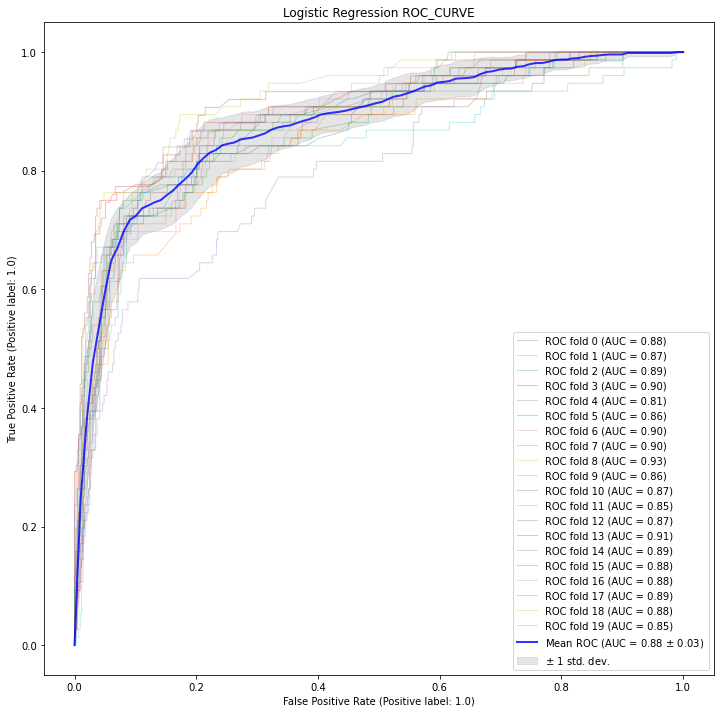

In [ ]:
#ROC_CURVE plot logistic regression
cv = StratifiedKFold(n_splits = 20, shuffle=True, random_state=0)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(12, 12))
for i, (train, test) in enumerate(cv.split(X_new, y)):
    log_reg_model.fit(X_new[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        log_reg_model,
        X_new[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Logistic Regression ROC_CURVE",
)
ax.legend(loc="lower right")
plt.show()

#see appendix 2.7 in the final report

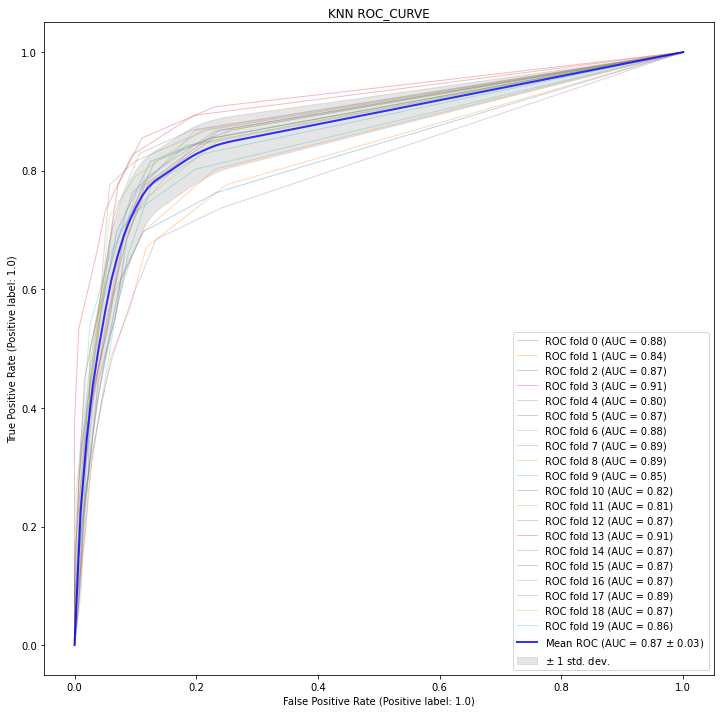

In [ ]:
#ROC_CURVE plot KNN
cv = StratifiedKFold(n_splits = 20, shuffle=True, random_state=0)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(12, 12))
for i, (train, test) in enumerate(cv.split(X_new, y)):
    knn_model.fit(X_new[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        knn_model,
        X_new[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="KNN ROC_CURVE",
)
ax.legend(loc="lower right")
plt.show()

#see appendix 2.7 in the final report

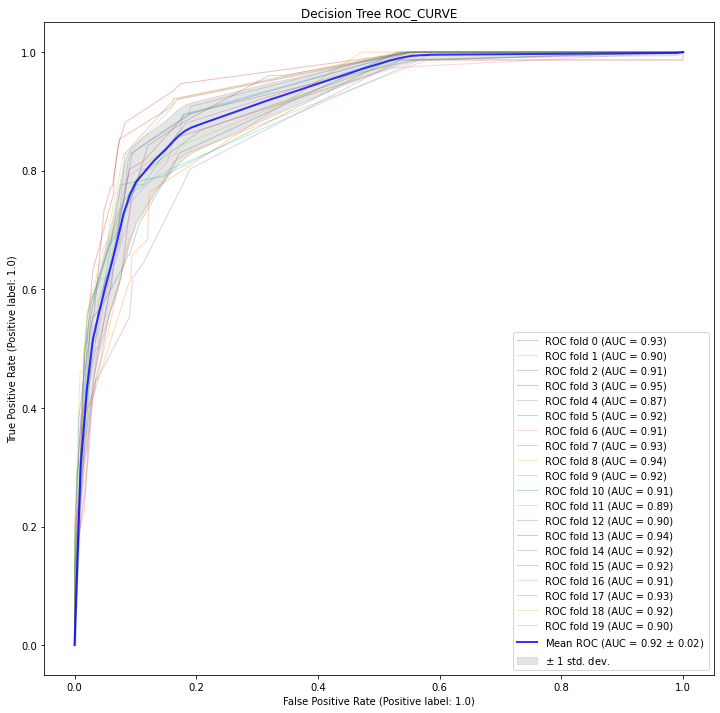

In [ ]:
#ROC_CURVE plot decision tree
cv = StratifiedKFold(n_splits = 20, shuffle=True, random_state=0)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(12, 12))
for i, (train, test) in enumerate(cv.split(X, y)):
    best_decition_tree.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        best_decition_tree,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Decision Tree ROC_CURVE",
)
ax.legend(loc="lower right")
plt.show()

#see appendix 2.7 in the final report

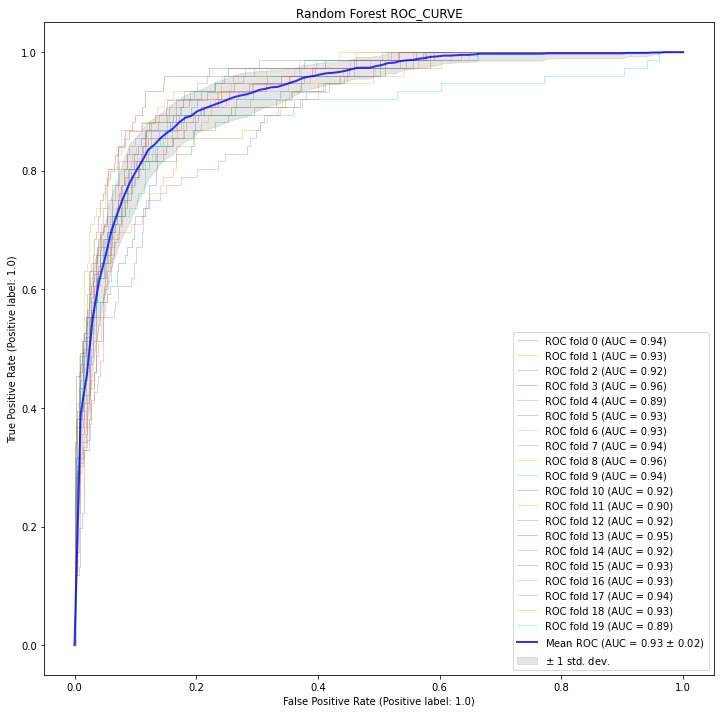

In [ ]:
#ROC_CURVE plot random forest
cv = StratifiedKFold(n_splits = 20, shuffle=True, random_state=0)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(12, 12))
for i, (train, test) in enumerate(cv.split(X, y)):
    best_forest.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        best_forest,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Random Forest ROC_CURVE",
)
ax.legend(loc="lower right")
plt.show()

#see appendix 2.7 in the final report

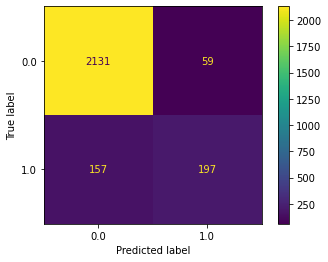

In [ ]:
#Cereating a confusion matrix to our chosen model - random forest

ConfusionMatrixDisplay.from_predictions(y_val, forest_pred_val)

#see appendix 2.8 in the final report

### Conclution from confusion matrix

We can see that we have 97% success when predicting the lable to be 0, but only about 55% success when predicting the lable to be 1.
That means we only get the right prediction for a purchase a little over half the times - the rate of false negative is relativly high.
To improve the model we could penelize false negative more than false positive, which will help predicting the "1" lable better - meaning we will be able to predict when a customer will buy with higher precision.

# Pipeline

In [ ]:
test = loading_csv("test.csv")
train_data = loading_csv("train.csv")

def pipeline(D, T, cols_dict, close_dict, forest_params):
    D = transform_data(D)
    T= transform_data(T)
    fill_all_nas(D, cols_dict, close_dict)
    fill_all_nas(T, cols_dict, close_dict)
    forest = RandomForestClassifier(**forest_params, random_state=0)
    target_col = D.pop("purchase")
    D.insert(30, "purchase", target_col)
    X, y = D.values[:,:-1], D.values[:, -1]
    forest.fit(X, y)
    X_test = T.values    
    test_pred = forest.predict_proba(X_test)
    test_pred = test_pred[:, 1]
    pd_test_pred = pd.DataFrame(test_pred, columns = ["predict_prob"])
    pd_test_pred.to_csv('Submission_group_14.csv', index_label = 'id')
    
pipeline(train_data, test, cols_fill_dict, closeness_dict, best_forest_params)